数据形状: (21000, 18)
训练数据形状: (16800, 18), 测试数据形状: (4200, 18)
使用数据中已有的rank_category列
排名类别映射: {'Top 10': 0, 'Top 100': 1, 'Top 200': 2, 'Top 50': 3}
使用数据中已有的rank_category列
排名类别映射: {'Top 10': 0, 'Top 100': 1, 'Top 200': 2, 'Top 50': 3}
使用以下特征: ['Hours_watched', 'Hours_streamed', 'Peak_viewers', 'Peak_channels']

请选择操作模式:
1. 训练新模型
2. 加载现有模型
3. 退出


请输入选择 (1-3):  1



正在准备训练数据...
处理了 252 个游戏，跳过了 1738 个数据不足的游戏
创建的序列数据: X shape = (7295, 6, 4), y shape = (7295, 12)

开始训练模型...
Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.0256 - loss: 83.9759 - val_accuracy: 0.0000e+00 - val_loss: 57.3676
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0278 - loss: 75.2536 - val_accuracy: 0.0000e+00 - val_loss: 89.9045
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.4732e-04 - loss: 84.5688 - val_accuracy: 0.0000e+00 - val_loss: 50.0097
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0000e+00 - loss: 54.6793 - val_accuracy: 0.0000e+00 - val_loss: 55.7800
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0050 - loss: 54.6777 - val_accuracy: 0.0000e+00 - val_loss: 50.6444
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0316 - loss: 51.9571 - val_accuracy: 0.0000e+00 - val_loss: 48.0252
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.0584 - 

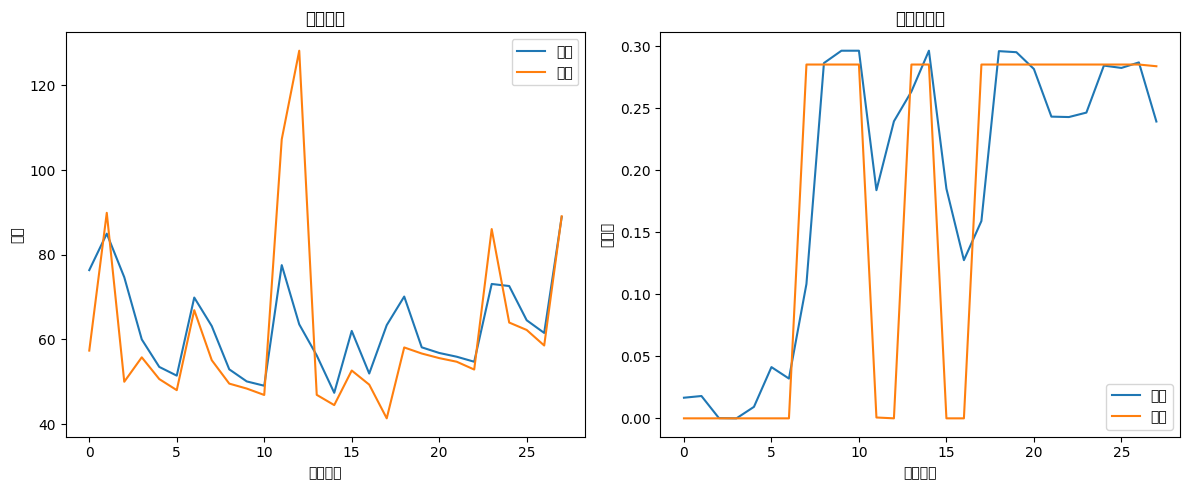


验证集评估:
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
第 1 个月的预测准确率: 0.2851, RMSE: 1.2391
第 2 个月的预测准确率: 0.0775, RMSE: 2.0315
第 3 个月的预测准确率: 0.2598, RMSE: 1.4807
第 4 个月的预测准确率: 0.0740, RMSE: 2.0548
第 5 个月的预测准确率: 0.0617, RMSE: 2.0715
第 6 个月的预测准确率: 0.0576, RMSE: 2.0611
第 7 个月的预测准确率: 0.0493, RMSE: 2.0444
第 8 个月的预测准确率: 0.0713, RMSE: 2.0429
第 9 个月的预测准确率: 0.0398, RMSE: 2.0763
第 10 个月的预测准确率: 0.0624, RMSE: 2.0579
第 11 个月的预测准确率: 0.0631, RMSE: 2.0370
第 12 个月的预测准确率: 0.0651, RMSE: 2.0444


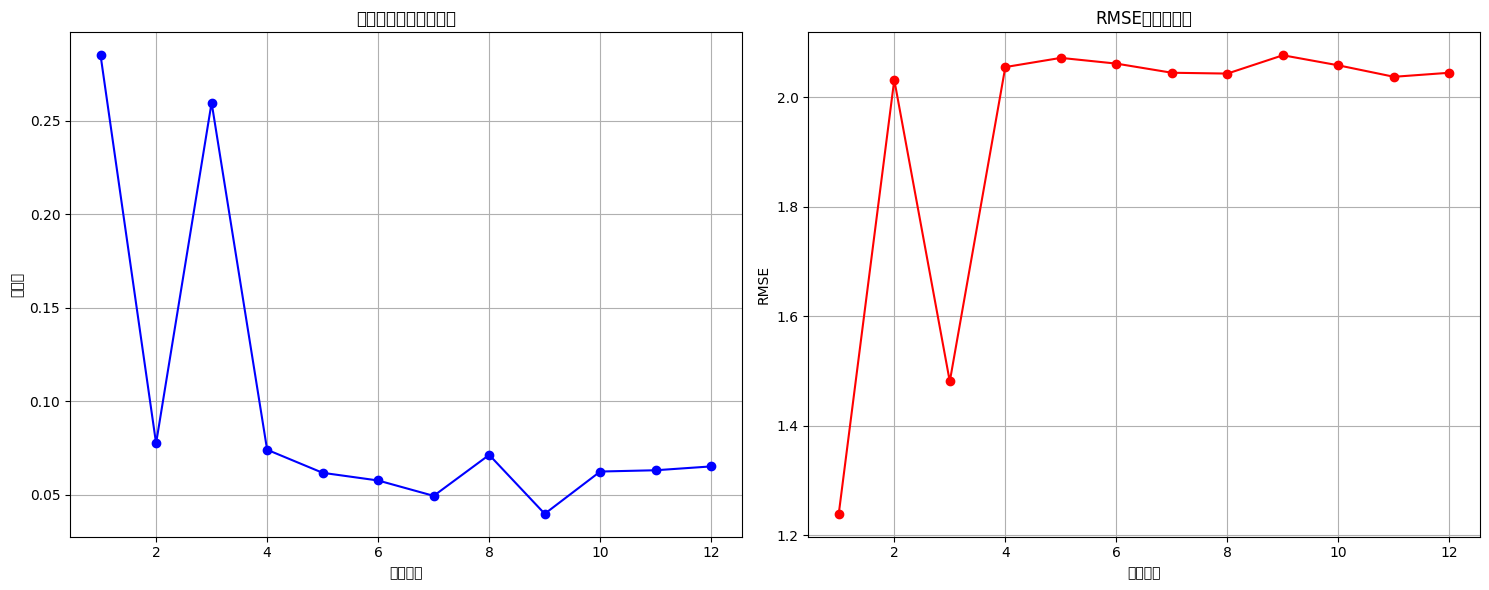

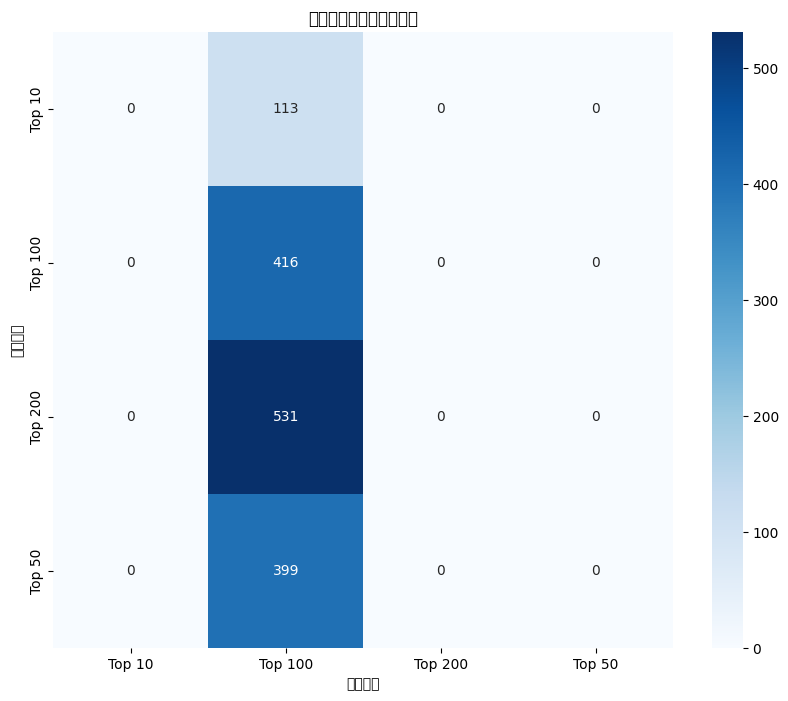


平均准确率: 0.0972, 平均RMSE: 1.9368
前6个月平均准确率: 0.1359, 前6个月平均RMSE: 1.8231
处理了 106 个游戏，跳过了 583 个数据不足的游戏

测试集评估:
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
第 1 个月的预测准确率: 0.3444, RMSE: 1.2080
第 2 个月的预测准确率: 0.0791, RMSE: 2.0146
第 3 个月的预测准确率: 0.2730, RMSE: 1.5017
第 4 个月的预测准确率: 0.0816, RMSE: 2.0373
第 5 个月的预测准确率: 0.0740, RMSE: 2.0696
第 6 个月的预测准确率: 0.0689, RMSE: 2.0782
第 7 个月的预测准确率: 0.0332, RMSE: 2.0904
第 8 个月的预测准确率: 0.0893, RMSE: 2.0429
第 9 个月的预测准确率: 0.0816, RMSE: 1.9788
第 10 个月的预测准确率: 0.0816, RMSE: 2.0880
第 11 个月的预测准确率: 0.0663, RMSE: 2.0825
第 12 个月的预测准确率: 0.0765, RMSE: 2.0720


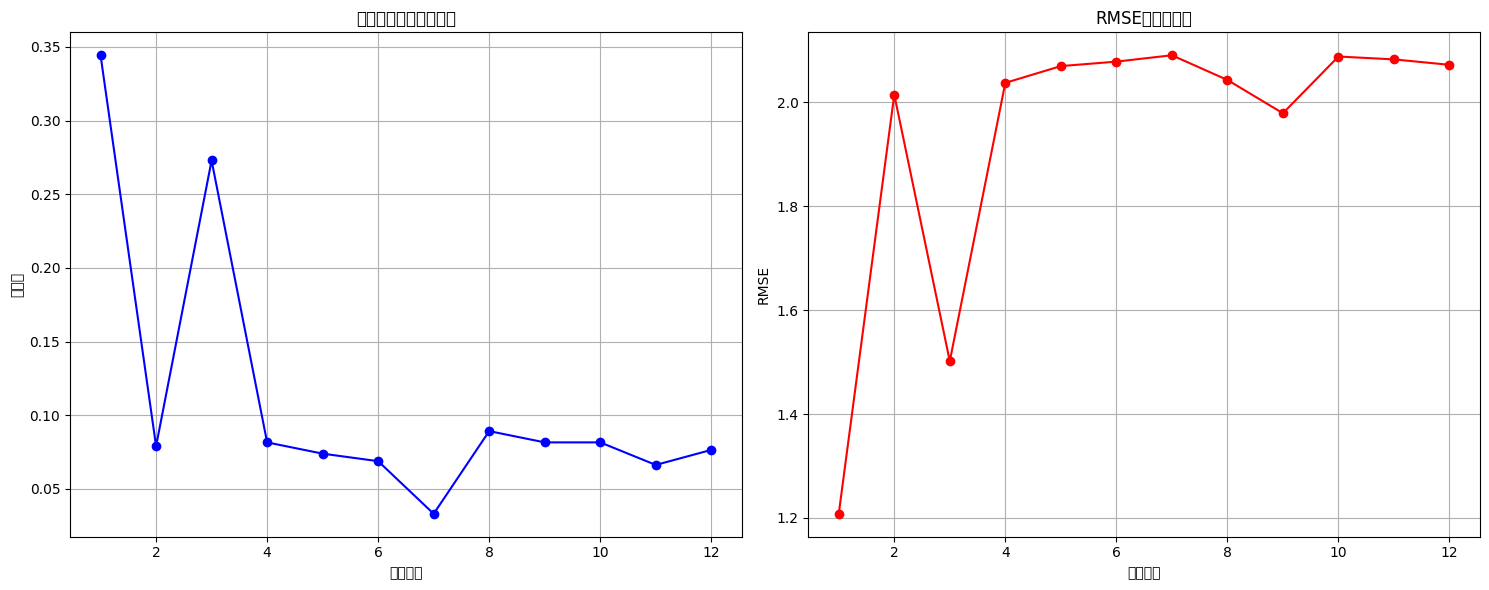

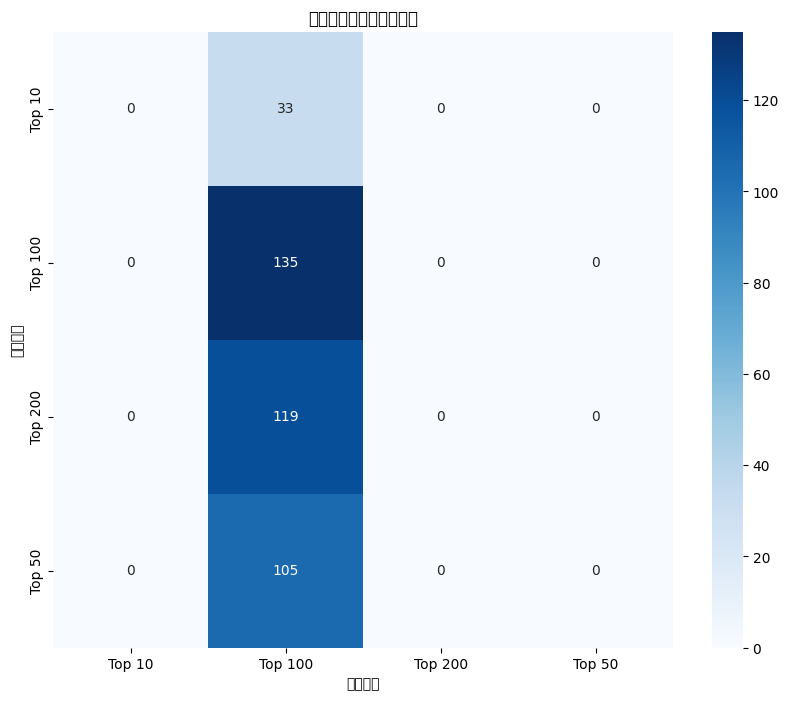


平均准确率: 0.1125, 平均RMSE: 1.9387
前6个月平均准确率: 0.1535, 前6个月平均RMSE: 1.8182

模型已保存为 'game_rank_lstm_model.h5'

可用游戏列表:
1. .hack//G.U. Last Recode
2. 20 Minutes Till Dawn
3. 2XKO
4. 60 Parsecs!
5. 60 Seconds!
6. 60 Seconds! Reatomized
7. 7 Days to Die
8. <U+014C>kami
9. A Dance of Fire and Ice
10. A Difficult Game About Climbing
11. A Hat in Time
12. A Plague Tale: Innocence
13. A Plague Tale: Requiem
14. A Total War Saga: Troy
15. A Way Out
16. Abandon Ship
17. Abiotic Factor
18. Absolver
19. ABZ<U+00DB>
20. Ace Combat 7: Skies Unknown
21. AFK Journey
22. Against the Storm
23. Agar.io
24. Age of Darkness: Final Stand
25. Age of Empires
26. Age of Empires II
27. Age of Empires II: Definitive Edition
28. Age of Empires II: HD Edition
29. Age of Empires IV
30. Age of Empires: Definitive Edition
31. Age of Mythology
32. Age of Wonders 4
33. Age of Wonders: Planetfall
34. Agents of Mayhem
35. Agony
36. Agrou
37. AI: The Somnium Files
38. Aim Gods
39. Aion
40. Aion Classic
41. Alan Wake II
42. Alan


请输入游戏编号 (1-2334):  1023

请输入要预测的点数 (1-12):  12



您选择了: League of Legends
预测未来 12 个点的排名
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


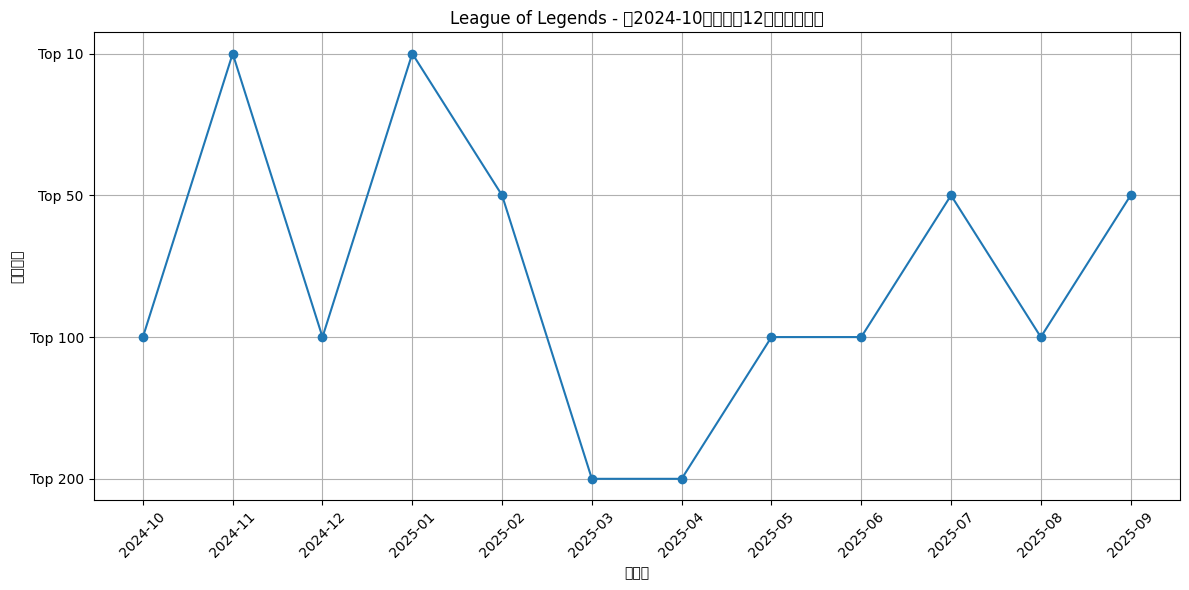


预测结果:
       Date Predicted_Rank_Category
0   2024-10                 Top 100
1   2024-11                  Top 10
2   2024-12                 Top 100
3   2025-01                  Top 10
4   2025-02                  Top 50
5   2025-03                 Top 200
6   2025-04                 Top 200
7   2025-05                 Top 100
8   2025-06                 Top 100
9   2025-07                  Top 50
10  2025-08                 Top 100
11  2025-09                  Top 50



是否继续预测其他游戏? (y/n):  n



请选择操作模式:
1. 训练新模型
2. 加载现有模型
3. 退出


请输入选择 (1-3):  3


退出程序。


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

# 1. 直接加载data.csv
def load_data():
    # 加载组合数据
    try:
        data = pd.read_csv('data.csv')
        print(f"数据形状: {data.shape}")
        
        # 分割训练和测试数据（按时间）
        if 'Year' in data.columns:
            train_data = data[data['Year'] < 2023].copy()
            test_data = data[data['Year'] >= 2023].copy()
            print(f"训练数据形状: {train_data.shape}, 测试数据形状: {test_data.shape}")
        else:
            # 如果没有Year列，使用随机分割
            print("警告: 数据中没有Year列，将随机分割数据")
            train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
        
        return train_data, test_data
    
    except Exception as e:
        print(f"加载数据时出错: {e}")
        raise

# 2. 创建排名类别
def create_rank_categories(df):
    # 检查是否已有rank_category列
    if 'rank_category' in df.columns:
        print("使用数据中已有的rank_category列")
        # 确保值是字符串类型
        df['Rank_Category'] = df['rank_category'].astype(str)
    else:
        # 创建新的排名类别
        print("创建新的排名类别")
        conditions = [
            (df['Rank'] <= 10),
            (df['Rank'] <= 50) & (df['Rank'] > 10),
            (df['Rank'] <= 100) & (df['Rank'] > 50),
            (df['Rank'] <= 200) & (df['Rank'] > 100)
        ]
        choices = ['Top 10', 'Top 50', 'Top 100', 'Top 200']
        df['Rank_Category'] = np.select(conditions, choices, default='Other')
    
    # 对类别进行编码
    label_encoder = LabelEncoder()
    df['Rank_Category_Encoded'] = label_encoder.fit_transform(df['Rank_Category'])
    
    # 保存编码映射，用于解释预测结果
    category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    reverse_mapping = {v: k for k, v in category_mapping.items()}
    
    print("排名类别映射:", category_mapping)
    return df, label_encoder, category_mapping, reverse_mapping

# 3. 数据预处理和标准化
def preprocess_data(train_df, test_df):
    # 基本特征列表 - 移除time_idx
    basic_features = ['Hours_watched', 'Hours_streamed', 'Peak_viewers', 'Peak_channels']
    
    # 检查特征列是否存在，只使用存在的列
    available_features = []
    for col in basic_features:
        if col in train_df.columns and col in test_df.columns:
            available_features.append(col)
        else:
            print(f"警告: {col} 列不存在，将不使用此特征")
    
    # 确保至少有一些特征可用
    if len(available_features) == 0:
        raise ValueError("没有找到任何可用的特征列")
    
    feature_columns = available_features
    print(f"使用以下特征: {feature_columns}")
    
    # 处理可能的NaN值
    for col in feature_columns:
        train_df[col] = train_df[col].fillna(train_df[col].mean())
        test_df[col] = test_df[col].fillna(train_df[col].mean())
    
    # 数值特征标准化
    scaler = MinMaxScaler()
    train_df[feature_columns] = scaler.fit_transform(train_df[feature_columns])
    test_df[feature_columns] = scaler.transform(test_df[feature_columns])
    
    return train_df, test_df, feature_columns, scaler

# 4. 创建序列数据
def create_sequences(df, games, feature_columns, sequence_length=6, forecast_horizon=12):
    """
    为每个游戏创建序列数据，用过去sequence_length个月的数据预测接下来的forecast_horizon个月
    """
    X, y = [], []
    game_indices = []
    
    skipped_games = 0
    processed_games = 0
    
    for game in games:
        # 选择特定游戏的数据
        game_data = df[df['Game'] == game]
        
        # 如果有Year和Month列，按这些列排序
        if 'Year' in game_data.columns and 'Month' in game_data.columns:
            game_data = game_data.sort_values(['Year', 'Month'])
        # 否则按原始顺序使用
        
        if len(game_data) < sequence_length + forecast_horizon:
            skipped_games += 1
            continue  # 跳过数据不足的游戏
        
        for i in range(len(game_data) - sequence_length - forecast_horizon + 1):
            X_sequence = game_data.iloc[i:i+sequence_length][feature_columns].values
            y_sequence = game_data.iloc[i+sequence_length:i+sequence_length+forecast_horizon]['Rank_Category_Encoded'].values
            
            X.append(X_sequence)
            y.append(y_sequence)
            game_indices.append(game)
        
        processed_games += 1
    
    print(f"处理了 {processed_games} 个游戏，跳过了 {skipped_games} 个数据不足的游戏")
    
    if not X:
        raise ValueError("没有足够的数据来创建序列。每个游戏可能没有足够的历史数据点。")
    
    return np.array(X), np.array(y), game_indices

# 5. 构建LSTM模型
def build_lstm_model(input_shape, num_classes, forecast_horizon):
    model = Sequential([
        LSTM(128, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(64, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(forecast_horizon * num_classes, activation='linear')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# 6. 训练模型
def train_model(X_train, y_train, X_val, y_val, num_classes, forecast_horizon):
    # 调整y的形状以适应多输出分类
    y_train_reshaped = np.zeros((y_train.shape[0], forecast_horizon, num_classes))
    for i in range(y_train.shape[0]):
        for j in range(forecast_horizon):
            if j < y_train.shape[1]:  # 确保不超出边界
                y_train_reshaped[i, j, y_train[i, j]] = 1
                
    y_val_reshaped = np.zeros((y_val.shape[0], forecast_horizon, num_classes))
    for i in range(y_val.shape[0]):
        for j in range(forecast_horizon):
            if j < y_val.shape[1]:  # 确保不超出边界
                y_val_reshaped[i, j, y_val[i, j]] = 1
    
    # 调整形状以适应LSTM输入
    y_train_reshaped = y_train_reshaped.reshape(y_train.shape[0], -1)
    y_val_reshaped = y_val_reshaped.reshape(y_val.shape[0], -1)
    
    # 构建模型
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_model(input_shape, num_classes, forecast_horizon)
    
    # 设置早停
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    # 训练模型
    history = model.fit(
        X_train, y_train_reshaped,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val_reshaped),
        callbacks=[early_stopping],
        verbose=1
    )
    
    return model, history

# 7. 评估和预测
def evaluate_model(model, X_test, y_test, num_classes, forecast_horizon, reverse_mapping):
    # 预测
    y_pred_proba = model.predict(X_test)
    
    # 重塑预测结果
    y_pred_proba = y_pred_proba.reshape(y_pred_proba.shape[0], forecast_horizon, num_classes)
    y_pred = np.argmax(y_pred_proba, axis=2)
    
    # 计算准确率和RMSE
    accuracies = []
    rmse_values = []
    for month in range(min(forecast_horizon, y_test.shape[1])):
        # 准确率 (分类指标)
        acc = accuracy_score(y_test[:, month], y_pred[:, month])
        accuracies.append(acc)
        
        # RMSE (回归指标)
        # 将类别值视为连续值 (0, 1, 2, 3) 计算RMSE
        rmse = np.sqrt(np.mean((y_test[:, month] - y_pred[:, month])**2))
        rmse_values.append(rmse)
        
        print(f"第 {month+1} 个月的预测准确率: {acc:.4f}, RMSE: {rmse:.4f}")
    
    # 可视化准确率和RMSE随预测时间变化
    plt.figure(figsize=(15, 6))
    
    # 准确率图
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', color='blue')
    plt.title('预测准确率随时间变化')
    plt.xlabel('预测月数')
    plt.ylabel('准确率')
    plt.grid(True)
    
    # RMSE图
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(rmse_values) + 1), rmse_values, marker='o', color='red')
    plt.title('RMSE随时间变化')
    plt.xlabel('预测月数')
    plt.ylabel('RMSE')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 为第一个月的预测结果绘制混淆矩阵
    if y_test.shape[1] > 0:
        cm = confusion_matrix(y_test[:, 0], y_pred[:, 0])
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=[reverse_mapping[i] for i in range(num_classes)],
                   yticklabels=[reverse_mapping[i] for i in range(num_classes)])
        plt.title('第一个月预测的混淆矩阵')
        plt.ylabel('真实类别')
        plt.xlabel('预测类别')
        plt.show()
    
    # 计算平均准确率和RMSE
    avg_accuracy = np.mean(accuracies)
    avg_rmse = np.mean(rmse_values)
    print(f"\n平均准确率: {avg_accuracy:.4f}, 平均RMSE: {avg_rmse:.4f}")
    
    # 计算并显示预测前6个月的整体指标
    if len(accuracies) >= 6:
        print(f"前6个月平均准确率: {np.mean(accuracies[:6]):.4f}, 前6个月平均RMSE: {np.mean(rmse_values[:6]):.4f}")
    
    return y_pred, accuracies, rmse_values

# 8. 对特定游戏进行预测
def predict_for_game(model, game_name, combined_df, feature_columns, scaler, sequence_length, 
                    forecast_horizon, num_classes, reverse_mapping):
    """预测游戏未来排名"""
    game_data = combined_df[combined_df['Game'] == game_name].copy()
    
    # 确保所有需要的列都存在
    for col in feature_columns:
        if col not in game_data.columns:
            raise ValueError(f"预测所需的特征列 '{col}' 不存在")
    
    # 如果有Year和Month列，按这些列排序
    if 'Year' in game_data.columns and 'Month' in game_data.columns:
        game_data = game_data.sort_values(['Year', 'Month'])
    
    if len(game_data) < sequence_length:
        print(f"游戏 {game_name} 的历史数据不足 {sequence_length} 个点，无法预测")
        return None
    
    # 获取最近的数据点
    recent_data = game_data.iloc[-sequence_length:][feature_columns].values
    recent_data = recent_data.reshape(1, sequence_length, len(feature_columns))
    
    # 预测
    prediction = model.predict(recent_data)
    prediction = prediction.reshape(1, forecast_horizon, num_classes)
    prediction_classes = np.argmax(prediction, axis=2)[0]
    
    # 转换为类别名称
    prediction_categories = [reverse_mapping[pred] for pred in prediction_classes]
    
    # 获取最后一个时间点
    if 'Year' in game_data.columns and 'Month' in game_data.columns:
        last_record = game_data.iloc[-1]
        last_month = last_record['Month']
        last_year = last_record['Year']
        
        # 计算未来月份
        future_dates = []
        for i in range(forecast_horizon):
            future_month = (last_month + i) % 12 + 1  # 1-12
            future_year = last_year + (last_month + i) // 12
            future_dates.append(f"{future_year}-{future_month:02d}")
    else:
        # 如果没有Year和Month列，使用数字索引
        future_dates = [f"预测点 {i+1}" for i in range(forecast_horizon)]
    
    # 创建预测结果DataFrame
    results = pd.DataFrame({
        'Date': future_dates,
        'Predicted_Rank_Category': prediction_categories
    })
    
    # 可视化预测结果
    plt.figure(figsize=(12, 6))
    category_values = {'Top 10': 4, 'Top 50': 3, 'Top 100': 2, 'Top 200': 1}
    result_values = [category_values[cat] for cat in prediction_categories]
    
    plt.plot(future_dates, result_values, marker='o', linestyle='-')
    plt.title(f'{game_name} - 从{future_dates[0]}开始未来{forecast_horizon}个点排名预测')
    plt.xlabel('时间点')
    plt.ylabel('排名类别')
    plt.yticks([1, 2, 3, 4], ['Top 200', 'Top 100', 'Top 50', 'Top 10'])
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return results

# 9. 用户交互函数
def user_interaction(combined_data, model=None):
    """允许用户选择游戏和预测月数，并显示预测结果"""
    
    # 获取所有可用的游戏列表并标准化处理
    game_set = set()
    game_map = {}  # 用于映射显示名称到原始名称
    
    # 处理游戏列表
    for game in combined_data['Game'].unique():
        if pd.isna(game):
            continue
            
        if isinstance(game, (int, float)):
            game = str(game)
            
        # 使用小写版本作为标识符，避免大小写导致的重复
        game_lower = game.lower()
        if game_lower not in game_set:
            game_set.add(game_lower)
            game_map[game_lower] = game  # 保存原始大小写
    
    # 获取排序后的唯一游戏列表（使用原始大小写显示）
    all_games_lower = sorted(game_set)
    all_games = [game_map[game_lower] for game_lower in all_games_lower]
    
    # 显示游戏列表
    print("\n可用游戏列表:")
    for i, game in enumerate(all_games):
        print(f"{i+1}. {game}")
    
    # 让用户选择游戏
    while True:
        try:
            choice = int(input("\n请输入游戏编号 (1-{}): ".format(len(all_games))))
            if 1 <= choice <= len(all_games):
                selected_game = all_games[choice-1]
                break
            else:
                print("无效的选择，请重新输入。")
        except ValueError:
            print("请输入有效的数字。")
    
    # 让用户选择预测点数
    while True:
        try:
            forecast_points = int(input("\n请输入要预测的点数 (1-12): "))
            if 1 <= forecast_points <= 12:
                break
            else:
                print("请输入1到12之间的数字。")
        except ValueError:
            print("请输入有效的数字。")
    
    print(f"\n您选择了: {selected_game}")
    print(f"预测未来 {forecast_points} 个点的排名")
    
    return selected_game, forecast_points

# 10. 主函数
def main():
    try:
        # 加载数据
        train_data, test_data = load_data()
        
        # 将训练和测试数据合并为一个数据集以便用户选择
        combined_data = pd.concat([train_data, test_data])
        
        # 创建排名类别
        train_data, label_encoder, category_mapping, reverse_mapping = create_rank_categories(train_data)
        test_data, _, _, _ = create_rank_categories(test_data)
        
        # 设置num_classes为全局变量
        global num_classes
        num_classes = len(category_mapping)
        
        # 数据预处理
        train_data, test_data, feature_columns, scaler = preprocess_data(train_data, test_data)
        
        # 选择操作模式
        while True:
            print("\n请选择操作模式:")
            print("1. 训练新模型")
            print("2. 加载现有模型")
            print("3. 退出")
            
            choice = input("请输入选择 (1-3): ")
            
            if choice == '1':
                # 设置序列长度和预测范围
                sequence_length = 6  # 使用过去6个点的数据
                forecast_horizon = 12  # 预测未来12个点
                
                # 获取所有游戏名称
                games = train_data['Game'].unique()
                
                # 创建序列数据
                try:
                    print("\n正在准备训练数据...")
                    X, y, game_indices = create_sequences(
                        train_data, games, feature_columns, 
                        sequence_length, forecast_horizon
                    )
                    
                    print(f"创建的序列数据: X shape = {X.shape}, y shape = {y.shape}")
                    
                    # 分割训练集和验证集
                    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
                    
                    # 训练模型
                    print("\n开始训练模型...")
                    model, history = train_model(X_train, y_train, X_val, y_val, num_classes, forecast_horizon)
                    
                    # 可视化训练历史
                    plt.figure(figsize=(12, 5))
                    plt.subplot(1, 2, 1)
                    plt.plot(history.history['loss'])
                    plt.plot(history.history['val_loss'])
                    plt.title('模型损失')
                    plt.ylabel('损失')
                    plt.xlabel('训练轮次')
                    plt.legend(['训练', '验证'], loc='upper right')
                    
                    plt.subplot(1, 2, 2)
                    plt.plot(history.history['accuracy'])
                    plt.plot(history.history['val_accuracy'])
                    plt.title('模型准确率')
                    plt.ylabel('准确率')
                    plt.xlabel('训练轮次')
                    plt.legend(['训练', '验证'], loc='lower right')
                    plt.tight_layout()
                    plt.show()
                    
                    # 评估模型
                    print("\n验证集评估:")
                    y_val_pred, val_accuracies, val_rmse_values = evaluate_model(
                        model, X_val, y_val, num_classes, forecast_horizon, reverse_mapping
                    )
                    
                    # 为测试集准备数据
                    try:
                        test_games = test_data['Game'].unique()
                        X_test, y_test, test_game_indices = create_sequences(
                            test_data, test_games, feature_columns,
                            sequence_length, forecast_horizon
                        )
                        
                        if len(X_test) > 0:
                            print("\n测试集评估:")
                            y_test_pred, test_accuracies, test_rmse_values = evaluate_model(
                                model, X_test, y_test, num_classes, forecast_horizon, reverse_mapping
                            )
                    except Exception as e:
                        print(f"测试集评估出错: {e}")
                    
                    # 保存模型
                    model.save('game_rank_lstm_model.h5')
                    print("\n模型已保存为 'game_rank_lstm_model.h5'")
                    
                except Exception as e:
                    print(f"训练过程出错: {e}")
                    import traceback
                    traceback.print_exc()
                    continue
                
                # 用户交互预测部分
                while True:
                    # 让用户选择游戏和预测点数
                    selected_game, forecast_points = user_interaction(combined_data)
                    
                    # 查找数据中是否存在这个游戏（不区分大小写）
                    games_lower = [g.lower() if isinstance(g, str) else str(g).lower() for g in combined_data['Game'].unique()]
                    selected_game_lower = selected_game.lower()
                    
                    if selected_game_lower in games_lower:
                        # 找到原始大小写的游戏名
                        original_games = combined_data['Game'].unique()
                        for g in original_games:
                            if isinstance(g, str) and g.lower() == selected_game_lower:
                                original_game = g
                                break
                            elif not isinstance(g, str) and str(g).lower() == selected_game_lower:
                                original_game = g
                                break
                        
                        # 进行预测
                        try:
                            prediction = predict_for_game(
                                model, original_game, combined_data, feature_columns, scaler,
                                sequence_length, forecast_points, num_classes, reverse_mapping
                            )
                            
                            if prediction is not None:
                                print("\n预测结果:")
                                print(prediction)
                        except Exception as e:
                            print(f"预测出错: {e}")
                            import traceback
                            traceback.print_exc()
                    else:
                        print(f"警告：游戏 '{selected_game}' 在数据中不存在，无法预测。")
                    
                    continue_prediction = input("\n是否继续预测其他游戏? (y/n): ")
                    if continue_prediction.lower() != 'y':
                        break
                
            elif choice == '2':
                # 加载现有模型
                try:
                    from tensorflow.keras.models import load_model
                    model = load_model('game_rank_lstm_model.h5')
                    print("模型加载成功!")
                    
                    # 设置序列长度
                    sequence_length = 6  # 使用过去6个点的数据
                    
                    # 用户交互预测部分
                    while True:
                        # 让用户选择游戏和预测点数
                        selected_game, forecast_points = user_interaction(combined_data, model)
                        
                        # 查找数据中是否存在这个游戏（不区分大小写）
                        games_lower = [g.lower() if isinstance(g, str) else str(g).lower() for g in combined_data['Game'].unique()]
                        selected_game_lower = selected_game.lower()
                        
                        if selected_game_lower in games_lower:
                            # 找到原始大小写的游戏名
                            original_games = combined_data['Game'].unique()
                            for g in original_games:
                                if isinstance(g, str) and g.lower() == selected_game_lower:
                                    original_game = g
                                    break
                                elif not isinstance(g, str) and str(g).lower() == selected_game_lower:
                                    original_game = g
                                    break
                            
                            # 进行预测
                            try:
                                prediction = predict_for_game(
                                    model, original_game, combined_data, feature_columns, scaler,
                                    sequence_length, forecast_points, num_classes, reverse_mapping
                                )
                                
                                if prediction is not None:
                                    print("\n预测结果:")
                                    print(prediction)
                            except Exception as e:
                                print(f"预测出错: {e}")
                                import traceback
                                traceback.print_exc()
                        else:
                            print(f"警告：游戏 '{selected_game}' 在数据中不存在，无法预测。")
                        
                        continue_prediction = input("\n是否继续预测其他游戏? (y/n): ")
                        if continue_prediction.lower() != 'y':
                            break
                    
                except Exception as e:
                    print(f"加载模型出错: {e}")
                    print("请先训练模型或确保模型文件存在。")
            
            elif choice == '3':
                print("退出程序。")
                break
            
            else:
                print("无效选择，请重新输入。")
    except Exception as e:
        print(f"程序运行出错: {e}")
        # 显示详细错误信息，便于调试
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    # 全局变量初始化
    num_classes = 4
    main()